In [78]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib.lines import Line2D
from sklearn.covariance import MinCovDet
from sklearn.preprocessing import StandardScaler
from statannotations.Annotator import Annotator


from src.models.outliers import logratio_outlier_detection
from src.util import calculate_difference_to_controls
from src.config import get_hussmann_supplementary_xlsx, HOME_PATH, FILTER_COUNT, METHOD, PROFILE_TYPE, SAMPLE, PAIRED_SAMPLES, get_experiment_artifacts

In [80]:
sns.set_theme(style="white", palette="muted", font_scale=1.3)

import matplotlib as mpl

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True


In [81]:
# load data
Z_sample = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=SAMPLE)), "rb"))
Z_paired = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb"))
d_sample = pd.concat(Z_sample, axis=1)
d_paired = pd.concat(Z_paired, axis=1)

# get controls
controls = d_sample.index[d_sample.index.str.contains("non-")].to_list()

# shape dataframes
Xall_paired = d_paired.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")
Xall_sample = d_sample.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")

# calculate mahalanobis distances
results = {}
for alias in Z_paired.keys():
    pca_scores, loadings, explained_variance_ratio, distances, pvalues = logratio_outlier_detection(Z_paired[alias], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues
    results[alias] = pd.Series(distances, index=Z_paired[alias].index).sort_values(ascending=False)

# get pseudo controls
# Note: Adamson has only 1 target site
pseudo_controls = results[alias].iloc[-len(controls):].index.to_series()
pseudo_controls[:5]


# get differences to controls
idx = pd.IndexSlice
other_genes = set(Xall_paired.index.unique(1)) - set(controls) - set(pseudo_controls)
other_genes = list(other_genes)

Xdiff = calculate_difference_to_controls(Xall_sample, controls, d_sample.columns.unique(0))
Xdiff = Xdiff.loc[other_genes]

Xpseudodiff = {}
for alias in Z_sample.keys():
    Xpseudodiff[alias] = calculate_difference_to_controls(Xall_sample.loc[Xall_sample.index.get_level_values(0) == alias, :],\
                            pseudo_controls, [alias]).loc[other_genes]
Xpseudodiff = pd.concat(Xpseudodiff.values(), axis=1)


(992, 7)
(58, 7)
(496, 14)
(14,)
(496, 14)
(496, 7)
(29, 7)
(496, 7)
(7,)
(496, 7)
(496, 7)
(29, 7)
(496, 7)
(7,)
(496, 7)


/Users/colm/repos/MUSICian/src/util.py:21: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=X.index.unique(0), columns=X.columns)
/Users/colm/repos/MUSICian/src/util.py:21: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=X.index.unique(0), columns=X.columns)
/Users/colm/repos/MUSICian/src/util.py:21: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=X.index.unique(0), columns=X.columns)


In [82]:
def consistency(x, change_df, sample1, sample2, method="pearson"):
    if method == "spearman":
        return stats.spearmanr(change_df.loc[x,sample1].dropna(), change_df.loc[x,sample2].dropna())[0]
    if method == "pearson":
        return stats.pearsonr(change_df.loc[x,sample1].dropna(), change_df.loc[x,sample2].dropna())[0]

real_c = Xdiff.index.to_series().apply(lambda x: consistency(x, Xdiff, \
            "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1", "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2"))
pseudo_c = Xpseudodiff.index.to_series().apply(lambda x: consistency(x, Xpseudodiff, \
            "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1", "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2"))

In [83]:
real_c.mean()

0.5495907285068379

In [84]:
pseudo_c.mean()

0.5602169918377047

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


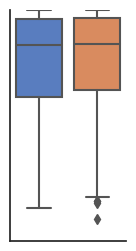

In [182]:
from scipy.stats import kstest
from statannotations.stats.StatTest import StatTest


# plt.title("Correlation of changes in frequency\nrelative to geometric mean\ncontrol spectra in Adamson T1")
# plt.xlabel("Controls")
# pairs=[("real", "pseudo")]
# annotator = Annotator(g, pairs, data=c, x="Type", y="Spearman's\nCorrelation Coef")
# # annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
# annotator.configure(test=custom_test, text_format="star", loc="inside")
# annotator.apply_and_annotate()
# plt.xticks([0, 1], ["non-targeting", "pseudo"])
# plt.tight_layout()
# plt.gcf().savefig("artifacts/fig_6c.pdf")
# plt.gcf().savefig("artifacts/fig_6c.png")

def plot_correlation_of_changes_in_frequency_relative_to_geomean(ax, real_c, pseudo_c):
    custom_test = StatTest(kstest, "Kolmogorov-Smirnov test for goodness of fit", "KS Test")
    c = pd.DataFrame({
        "Real": real_c,
        "Pseudo": pseudo_c
    }).stack()\
    .to_frame()\
    .reset_index()\
    .rename(columns={"level_1": "Type", 0: "Pearson's Corr. Coef"})
    g = sns.boxplot(data=c, x="Type", y="Pearson's Corr. Coef", ax=ax)
    # g.set_title("Corr. of freq. changes\nrelative to geo. mean")
    g.set_xlabel(None)
    g.set_ylabel(None)
    g.set_ylim(-1,1)
    g.set_xticklabels([])
    g.set_yticklabels([])

fig, ax = plt.subplots(1, 1, figsize=(9/6, 3))
plot_correlation_of_changes_in_frequency_relative_to_geomean(ax, real_c, pseudo_c)
plt.show()

In [102]:
# load data
Z = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=SAMPLE)), "rb"))
Z.update(pd.read_pickle(get_experiment_artifacts(profile_type=SAMPLE) + "imputed_sample_data.pkl"))
d = pd.concat(Z, axis=1)
common_genes = d.dropna().index

Xcommon_sample = d.loc[common_genes].stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")

# calculate mahalanobis distances
results = {}
pseudo_controls = {}
for alias in Z.keys():
    pca_scores, loadings, explained_variance_ratio, distances, pvalues = \
        logratio_outlier_detection(Z[alias].loc[common_genes], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues
    results[alias] = pd.Series(distances, index=Z[alias].loc[common_genes].index).sort_values(ascending=False)
    pseudo_controls[alias] = results[alias].iloc[-len(controls):].index.to_series()

Xpseudodiff = {}
for alias in Z.keys():
    Xpseudodiff[alias] = calculate_difference_to_controls(Xcommon_sample.loc[Xcommon_sample.index.get_level_values(0) == alias, :],\
        pseudo_controls[alias], [alias])
Xpseudodiff = pd.concat(Xpseudodiff.values(), axis=1)

adamson_t1 = Xpseudodiff.index.to_series().apply(lambda x: consistency(x, Xpseudodiff, \
            "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1", "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2"))
t1 = Xpseudodiff.index.to_series().apply(lambda x: consistency(x, Xpseudodiff, \
            "MB01", "MB02"))
t2 = Xpseudodiff.index.to_series().apply(lambda x: consistency(x, Xpseudodiff, \
            "MB03", "MB04"))
t3 = Xpseudodiff.index.to_series().apply(lambda x: consistency(x, Xpseudodiff, \
            "MB05", "MB06"))

(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)


/Users/colm/repos/MUSICian/src/util.py:21: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=X.index.unique(0), columns=X.columns)
/Users/colm/repos/MUSICian/src/util.py:21: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=X.index.unique(0), columns=X.columns)
/Users/colm/repos/MUSICian/src/util.py:21: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=X.index.unique(0), columns=X.columns)
/Users/colm/repos/MUSICian/src/util.py:21: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecat

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


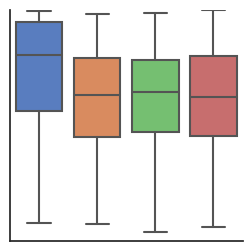

In [183]:

def plot_correlation_of_changes_to_geomean(ax, adamson_t1, t1, t2, t3):
    c = pd.DataFrame({
        "Adamson": adamson_t1,
        "T1": t1,
        "T2": t2,
        "T3": t3,
    }).stack()\
    .to_frame()\
    .reset_index()\
    .rename(columns={"level_1": "Target", 0: "Pearsons's Corr. Coef."})
    g = sns.boxplot(data=c, x="Target", y="Pearsons's Corr. Coef.", ax=ax)
    # ax.set_title("Corr. of freq. changes of gene to\nrelative to control geometric mean")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    g.set_xticklabels([])
    g.set_yticklabels([])
    ax.set_ylim(-1,1)
    return ax

fig, ax = plt.subplots(1, 1, figsize=((9/6)*2, 3))
plot_correlation_of_changes_to_geomean(ax, adamson_t1, t1, t2, t3)
plt.show()

In [11]:
full_results_df = pd.read_pickle(get_experiment_artifacts() + "/augmented_with_GO_outlier_results.pkl")
full_results_df.head()

Sample           Global                                                       \
Measure       Max Score Mean Consistency Mean Score Mean Std CLR Consistency   
Gene                                                                           
0610009B22Rik -0.202316        -0.263600  -0.487511                -0.864817   
0610010K14Rik -0.506267         0.404967  -0.554160                 0.147015   
0610030E20Rik -0.096154         0.068685  -0.334093                -0.104114   
0610040J01Rik  0.585708         0.337484   0.246902                -0.339103   
1110004F10Rik  0.243536        -0.194733   0.024213                -0.119202   

Sample                                          T1                         \
Measure       Mean Std Consistency CLR Consistency Consistency  distances   
Gene                                                                        
0610009B22Rik            -0.918179       -0.849354   -0.897694   0.169394   
0610010K14Rik             0.639911        0.689295    0.672534   1.420544   
0610030E20Rik            -0.108152        0.366741    0.528662   8.092794   
0610040J01Rik             0.485153        0.380555    0.580776  12.609331   
1110004F10Rik            -0.727883       -0.216158   -0.155832   9.343101   

Sample                               T2  ...              T3              \
Measure         pvalues CLR Consistency  ... CLR Consistency Consistency   
Gene                                     ...                               
0610009B22Rik  0.999409       -0.074988  ...        0.141639   -0.077164   
0610010K14Rik  0.922053       -0.149701  ...       -0.117280    0.561789   
0610030E20Rik  0.151195       -0.132531  ...       -0.118037   -0.279202   
0610040J01Rik  0.027328       -0.650751  ...        0.090293    0.499054   
1110004F10Rik  0.096137        0.086380  ...        0.283791   -0.373509   

Sample                             Gene Sets                             \
Measure        distances   pvalues   Adamson GeneSubset2 GeneSubsetSD30   
Gene                                                                      
0610009B22Rik   6.205324  0.286750     False       False          False   
0610010K14Rik   2.871384  0.719807     False       False          False   
0610030E20Rik   3.765686  0.583620     False       False          False   
0610040J01Rik  14.848909  0.011028     False       False          False   
1110004F10Rik  11.095744  0.049514     False       False          False   

Sample               Global                     
Measure       isGODSBRepair isGORepair isGODDR  
Gene                                            
0610009B22Rik         False      False   False  
0610010K14Rik         False      False   False  
0610030E20Rik         False      False   False  
0610040J01Rik         False      False   False  
1110004F10Rik         False      False   False  

[5 rows x 23 columns]

In [12]:
full_results_df[("Global", "isGORepair")].sum()

899

In [13]:
full_results_df["Global"].loc["Mnat1"]

Measure
Max Score                   1.904228
Mean Consistency            -0.09453
Mean Score                  0.864255
Mean Std CLR Consistency   -0.793413
Mean Std Consistency       -0.499881
isGODSBRepair                  False
isGORepair                      True
isGODDR                        False
Name: Mnat1, dtype: object

In [14]:
all_c = full_results_df.xs("Consistency", level="Measure", axis=1)
all_c_mean = all_c.mean(axis=1, skipna=True)
all_c_std = all_c.std(axis=1, skipna=True)

In [15]:
repair = full_results_df[("Global", "isGORepair")].reset_index().droplevel(axis=1, level=1).rename(columns={"Global": "GO DSB Gene"}).set_index("Gene")
repair = list(repair["GO DSB Gene"][repair["GO DSB Gene"]].index)

In [16]:
DSBrepair = full_results_df[("Global", "isGODSBRepair")].reset_index().droplevel(axis=1, level=1).rename(columns={"Global": "GO DSB Gene"}).set_index("Gene")
DSBrepair = list(DSBrepair["GO DSB Gene"][DSBrepair["GO DSB Gene"]].index)

In [17]:
adamson = full_results_df[("Gene Sets", "Adamson")].reset_index().droplevel(axis=1, level=1).rename(columns={"Gene Sets": "Adamson"}).set_index("Gene")
adamson = list(adamson["Adamson"][adamson["Adamson"]].index)

In [18]:
def get_colors(genes, DSBrepair, repair):
    colors = {}
    for g in genes:
        if g in DSBrepair:
            colors[g] = sns.color_palette()[0]
            continue
        elif g in repair:
            colors[g] = sns.color_palette()[1]
            continue
        else:
            colors[g] = sns.color_palette()[2]
    return colors

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


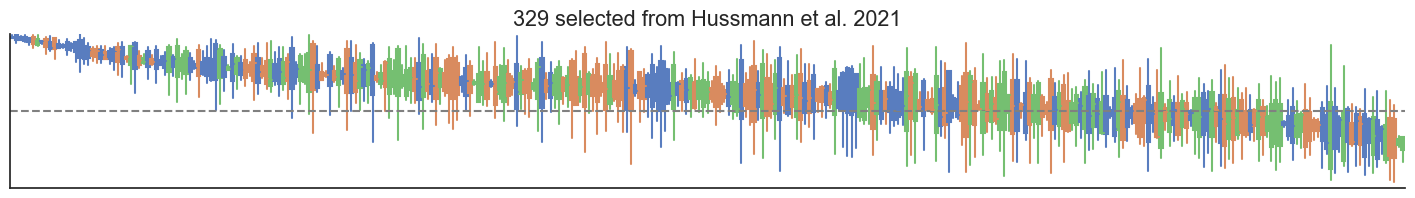

In [197]:
def corr_freq_change_across_replicates_annotated_by_GO_for_adamson(ax, all_c):
    scplot_df = all_c.loc[adamson, :].dropna()
    num_samples = scplot_df.shape[0]
    scplot_df = scplot_df.loc[all_c_mean.loc[scplot_df.index].sort_values(ascending=False).index].stack().to_frame().rename(columns={0: "Corr."}).reset_index()
    my_pal = get_colors(scplot_df.Gene.unique(), DSBrepair, repair)
    props = {
        'medianprops':{'color':'none'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}
    }
    g = sns.boxplot(data=scplot_df, x="Gene", y="Corr.", showcaps=False, palette=my_pal, ax=ax, **props)
    g.set(xticklabels=[])
    box_container = ax.patches if len(ax.patches) > 0 else ax.artists
    lines_per_boxplot = len(ax.lines) // len(box_container)
    for i, (box, xtick) in enumerate(zip(box_container, ax.get_xticklabels())):
        xtick.set_fontsize(20)
        color = box.get_facecolor()
        box.set_color(color)
        for lin in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            if lin.get_label() != 'median':
                lin.set_color(color)
                lin.set_markerfacecolor(color)
                lin.set_markeredgecolor(color)
    ax.axhline(0, color="grey", ls="--")
    ax.set_xlabel(None)
    ax.set_title("{} selected from Hussmann et al. 2021".format(num_samples))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.set_ylim(-1, 1)

fig, ax = plt.subplots(1, 1, figsize=((9/6)*12, 2))
corr_freq_change_across_replicates_annotated_by_GO_for_adamson(ax, all_c)
plt.show()

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


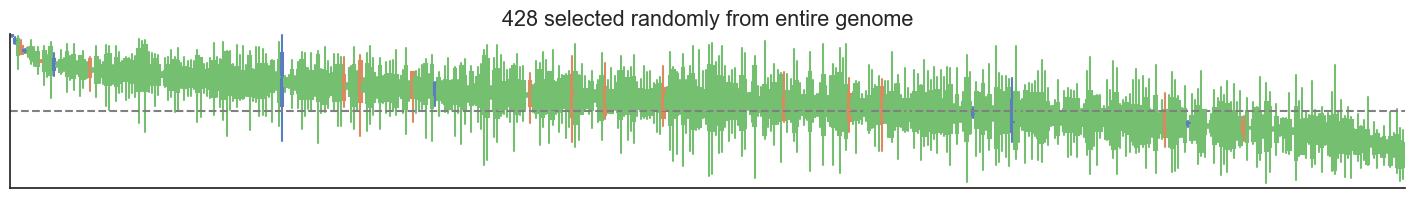

In [198]:
def corr_freq_change_across_replicates_annotated_by_GO_for_genome(ax, all_c):
    scplot_df = all_c.sample(len(adamson))
    num_samples = scplot_df.shape[0]
    scplot_df = scplot_df.loc[all_c_mean.loc[scplot_df.index].sort_values(ascending=False).index].stack().to_frame().rename(columns={0: "Corr."}).reset_index()
    my_pal = get_colors(scplot_df.Gene.unique(), DSBrepair, repair)
    props = {
        'medianprops':{'color':'none'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}
    }
    g = sns.boxplot(data=scplot_df, x="Gene", y="Corr.", showcaps=False, palette=my_pal, ax=ax, **props)
    g.set(xticklabels=[])
    box_container = ax.patches if len(ax.patches) > 0 else ax.artists
    lines_per_boxplot = len(ax.lines) // len(box_container)
    for i, (box, xtick) in enumerate(zip(box_container, ax.get_xticklabels())):
        xtick.set_fontsize(20)
        color = box.get_facecolor()
        box.set_color(color)
        for lin in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            if lin.get_label() != 'median':
                lin.set_color(color)
                lin.set_markerfacecolor(color)
                lin.set_markeredgecolor(color)
    custom_lines = [Line2D([0], [0], color=sns.color_palette()[0], lw=2),
                Line2D([0], [0], color=sns.color_palette()[1], lw=2),
                Line2D([0], [0], color=sns.color_palette()[2], lw=2)]
    # ax.legend(custom_lines, ["''double-strand break repair''", "''repair''", "Other/Not Annotated"], title='Annotated in Gene Ontology as...', ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
    ax.axhline(0, color="grey", ls="--")
    ax.set_xlabel(None)
    ax.set_title("{} selected randomly from entire genome".format(num_samples))
    # fig.suptitle("Correlation of change in frequency relative to controls between replicates of each MUSIC target site")
    ax.set_xticks([])
    ax.set_ylim(-1, 1)
    ax.set_yticks([])
    ax.set_ylabel("")

fig, ax = plt.subplots(1, 1, figsize=((9/6)*12, 2))
corr_freq_change_across_replicates_annotated_by_GO_for_genome(ax, all_c)
plt.show()

In [154]:
# plt.gcf().savefig("artifacts/fig_6f.pdf")
# plt.gcf().savefig("artifacts/fig_6f.png")

In [155]:
scplot_df = all_c.loc[adamson, :].dropna()
scplot_df = scplot_df.loc[all_c_mean.loc[scplot_df.index].sort_values(ascending=False).index]
scplot_df

Sample,T1,T2,T3
Gene,,,
Rnf8,0.949967,0.947352,0.984521
Xrcc6,0.877100,0.973540,0.998344
Fanca,0.918501,0.937632,0.975994
Poll,0.937663,0.889783,0.983431
Mre11a,0.851381,0.938384,0.947176
...,...,...,...
Nudt1,-0.609674,-0.671645,0.257790
Chd6,0.138099,-0.323928,-0.893888
Msh3,0.080365,-0.925891,-0.282767


In [156]:
def get_annotation(gene, DSBrepair, repair):
    if gene in DSBrepair:
        return "''double-strand break repair''"
    elif gene in repair:
        return "''repair''"
    return "Other/Not Annotated"

def add_labels(df, target_site, DSBrepair, repair):
    tmp = df[[target_site]].sort_values(target_site, ascending=False).copy()
    tmp["GO Annotation"] = tmp.index.to_series().apply(lambda x: get_annotation(x, DSBrepair, repair))
    return tmp.sort_values("GO Annotation")
    

add_labels(all_c.loc[adamson, :].dropna(), "T1", DSBrepair, repair)

Sample,T1,GO Annotation
Gene,,
Dmc1,0.287254,''double-strand break repair''
Brd7,0.485801,''double-strand break repair''
Poln,0.491239,''double-strand break repair''
Mgmt,0.071333,''double-strand break repair''
Mcm2,0.497388,''double-strand break repair''
...,...,...
Stag2,0.379791,Other/Not Annotated
Topors,0.389910,Other/Not Annotated
Bclaf1,0.392787,Other/Not Annotated


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_59651/2738700558.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df["GO DSB Repair"] = boxplot_df.index.isin(DSBrepair)
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

''double-strand break repair'' vs. Other/Not Annotated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.530e-05 U_stat=1.083e+04


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

''double-strand break repair'' vs. Other/Not Annotated: Mann-Whitney-Wilcoxon test two-sided, P_val:6.894e-06 U_stat=2.169e+06


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

''double-strand break repair'' vs. Other/Not Annotated: Mann-Whitney-Wilcoxon test two-sided, P_val:3.528e-16 U_stat=3.174e+06


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

''double-strand break repair'' vs. Other/Not Annotated: Mann-Whitney-Wilcoxon test two-sided, P_val:6.570e-10 U_stat=3.046e+06


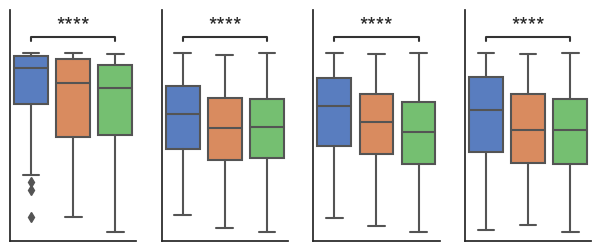

In [188]:
# fig = plt.figure(figsize=(7, 3.5))
# ax = fig.subplots(1, 4, sharey=True)

def corr_of_changes_across_GO_annotations(ax, full_results_df):
    boxplot_df = full_results_df.xs("Consistency", level=1, axis=1)
    boxplot_df["GO DSB Repair"] = boxplot_df.index.isin(DSBrepair)

    boxplot_df = boxplot_df.join(pseudo_c).rename(columns={"Gene": "Adamson"})
    target_sites = ["Adamson", "T1", "T2", "T3",]

    for i, t in enumerate(target_sites):
        bpdf = add_labels(boxplot_df[[t]], t, DSBrepair, repair)
        g = sns.boxplot(data=bpdf, y=t, x="GO Annotation", ax=ax[i])
        ax[i].set_xlabel(t)
        pairs=[("''double-strand break repair''", "Other/Not Annotated")]
        annotator = Annotator(ax[i], pairs, data=bpdf, y=t, x="GO Annotation")
        annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
        annotator.apply_test(alternative="greater")
        annotator.annotate()

        g.set_xticklabels([])
        g.set_yticklabels([])

    for a in ax:
        a.set_ylabel(None)
        a.set_xlabel(None)
        
    # custom_lines = [Line2D([0], [0], color=sns.color_palette()[0], lw=2),
    #                 Line2D([0], [0], color=sns.color_palette()[1], lw=2),
    #                 Line2D([0], [0], color=sns.color_palette()[2], lw=2)]

    # handles = [
    #     Patch(facecolor=sns.color_palette()[0], label="''double-strand break repair''") ,
    #     Patch(facecolor=sns.color_palette()[1], label="''repair''") ,
    #     Patch(facecolor=sns.color_palette()[2], label="Other/Not Annotated") 
    # ]
    # lgd = fig.legend(handles=handles, title='Annotated in Gene Ontology as...', ncols=1, loc="right", bbox_to_anchor=(1.4, 0.4))


    # mysuptitle = fig.suptitle('Correlation of changes in frequency relative to\ngeometric mean control spectra')
    # mysupxlabel = fig.supxlabel("Target", y=0.08)

fig, ax = plt.subplots(1, 4, figsize=((9/6)*5, 3))
corr_of_changes_across_GO_annotations(ax, full_results_df)
plt.show()

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a futu

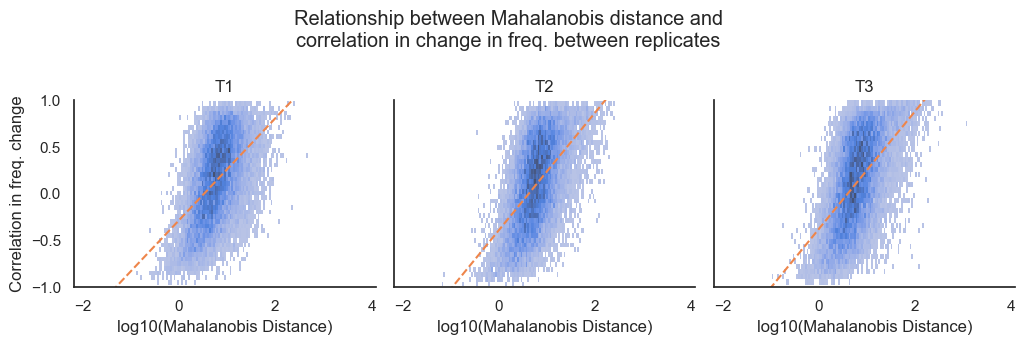

In [23]:
import statsmodels.api as sm

def abline(slope, intercept, axes):
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    axes.set_ylim((-1, 1))
    axes.plot(x_vals, y_vals, '--', c=sns.color_palette()[1])

scatter_df = {}
for t in target_sites[1:]:
    scatter_df[t] = full_results_df[t][["Consistency", "distances"]]
scatter_df = pd.concat(scatter_df).reset_index().rename(columns={"level_0": "Target Site"})
scatter_df["distances"] = np.log10(scatter_df["distances"])
scatter_df["annotation"] = scatter_df["Gene"].apply(lambda gene: get_annotation(gene, DSBrepair, repair))

g = sns.FacetGrid(data=scatter_df, col="Target Site", col_wrap=3, height=3.5, aspect=1, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, y="Consistency", x="distances")
# g.add_legend()
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_ylabels("Correlation in freq. change")
g.set_xlabels("log10(Mahalanobis Distance)")
g.figure.suptitle('Relationship between Mahalanobis distance and\ncorrelation in change in freq. between replicates')

for i, t in enumerate(["T1", "T2", "T3"]):
    tmp = scatter_df[scatter_df["Target Site"] == t].dropna()
    x = sm.add_constant(tmp["distances"].values)
    y = tmp["Consistency"].values
    model = sm.OLS(y, x)
    r = model.fit()
    intercept, slope = r.params
    abline(slope, intercept, g.axes[i])


g.tight_layout()

plt.gcf().savefig("artifacts/fig_6b.pdf")
plt.gcf().savefig("artifacts/fig_6b.png")

In [24]:
# load data
Z = pkl.load(open("{}/imputed_sample_data.pkl".format(get_experiment_artifacts(profile_type=SAMPLE)), "rb"))
# del Z["MB01"]
# del Z["MB02"]
d = pd.concat(Z, axis=1).dropna()

X_sample = d.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")

# calculate mahalanobis distances
results = {}
pseudo_controls = {}
for alias in Z.keys():
    pca_scores, loadings, explained_variance_ratio, distances, pvalues = \
        logratio_outlier_detection(Z[alias], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues
    results[alias] = pd.Series(distances, index=Z[alias].index).sort_values(ascending=False)
    pseudo_controls[alias] = results[alias].iloc[-len(controls):].index.to_series()

Xpseudodiff = {}
for alias in Z.keys():
    Xpseudodiff[alias] = calculate_difference_to_controls(X_sample.loc[X_sample.index.get_level_values(0) == alias, :],\
        pseudo_controls[alias], [alias])
Xpseudodiff = pd.concat(Xpseudodiff.values(), axis=1)

(16244, 7)
(28, 7)
(16244, 7)
(7,)
(16244, 7)
(16244, 7)
(29, 7)
(16244, 7)
(7,)
(16244, 7)
(16244, 7)
(28, 7)


/Users/colm/repos/MUSICian/src/util.py:21: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=X.index.unique(0), columns=X.columns)
/Users/colm/repos/MUSICian/src/util.py:21: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=X.index.unique(0), columns=X.columns)
/Users/colm/repos/MUSICian/src/util.py:21: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=X.index.unique(0), columns=X.columns)


(16244, 7)
(7,)
(16244, 7)
(16244, 7)
(29, 7)
(16244, 7)
(7,)
(16244, 7)
(16244, 7)
(29, 7)
(16244, 7)
(7,)
(16244, 7)
(16244, 7)
(28, 7)
(16244, 7)
(7,)
(16244, 7)


/Users/colm/repos/MUSICian/src/util.py:21: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=X.index.unique(0), columns=X.columns)
/Users/colm/repos/MUSICian/src/util.py:21: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=X.index.unique(0), columns=X.columns)
/Users/colm/repos/MUSICian/src/util.py:21: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=0).apply(stats.gmean).values.tolist(), index=X.index.unique(0), columns=X.columns)


Index(['Gene', 'lumc_category', 'MB01', 'MB02'], dtype='object', name='Sample')


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Index(['Gene', 'lumc_category', 'MB03', 'MB04'], dtype='object', name='Sample')


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Index(['Gene', 'lumc_category', 'MB05', 'MB06'], dtype='object', name='Sample')


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


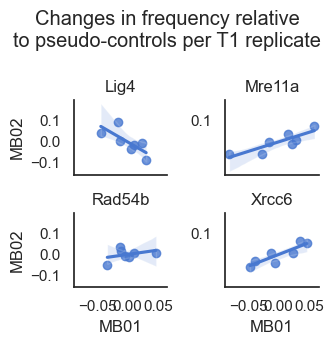

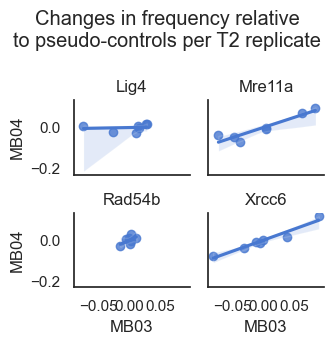

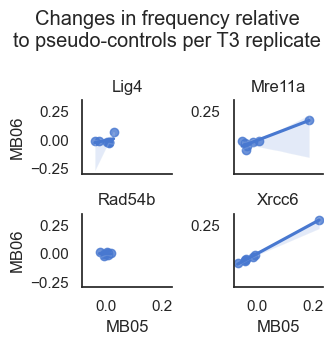

In [25]:
genes_to_plot = ["Mre11a", "Rad54b", "Lig4", "Xrcc6"]

plot_df = Xpseudodiff.T.loc[["MB01", "MB02"]].stack().reset_index().pivot(index=["Gene", "lumc_category"], columns="Sample", values=0).reset_index()
plot_df = plot_df[plot_df["Gene"].isin(genes_to_plot)]
print(plot_df.columns)
g = sns.FacetGrid(data=plot_df.sort_values(by="Gene"), col="Gene", col_wrap=2, height=1.75, aspect=1, sharex=True, sharey=True)

def f(x, y, z,**kwargs):
    ax = sns.regplot(x=x,y=y,**kwargs)
    data = kwargs["data"]
    l = data[x].shape[0]

g.map_dataframe(f, x="MB01", y="MB02", z="lumc_category")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_xlabels("MB01")
g.set_ylabels("MB02")
g.figure.suptitle('Changes in frequency relative\nto pseudo-controls per T1 replicate')
g.tight_layout()
plt.gcf().savefig("artifacts/fig_6aa.pdf")
plt.gcf().savefig("artifacts/fig_6aa.png")

plot_df = Xpseudodiff.T.loc[["MB03", "MB04"]].stack().reset_index().pivot(index=["Gene", "lumc_category"], columns="Sample", values=0).reset_index()
plot_df = plot_df[plot_df["Gene"].isin(genes_to_plot)]
print(plot_df.columns)
g = sns.FacetGrid(data=plot_df.sort_values(by="Gene"), col="Gene", col_wrap=2, height=1.75, aspect=1, sharex=True, sharey=True)

def f(x, y, z,**kwargs):
    ax = sns.regplot(x=x,y=y,**kwargs)
    data = kwargs["data"]
    l = data[x].shape[0]

g.map_dataframe(f, x="MB03", y="MB04", z="lumc_category")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_xlabels("MB03")
g.set_ylabels("MB04")
g.figure.suptitle('Changes in frequency relative\nto pseudo-controls per T2 replicate')
g.tight_layout()
plt.gcf().savefig("artifacts/fig_6ab.pdf")
plt.gcf().savefig("artifacts/fig_6ab.png")

plot_df = Xpseudodiff.T.loc[["MB05", "MB06"]].stack().reset_index().pivot(index=["Gene", "lumc_category"], columns="Sample", values=0).reset_index()
plot_df = plot_df[plot_df["Gene"].isin(genes_to_plot)]
print(plot_df.columns)
g = sns.FacetGrid(data=plot_df.sort_values(by="Gene"), col="Gene", col_wrap=2, height=1.75, aspect=1, sharex=True, sharey=True)

def f(x, y, z,**kwargs):
    ax = sns.regplot(x=x,y=y,**kwargs)
    data = kwargs["data"]
    l = data[x].shape[0]

g.map_dataframe(f, x="MB05", y="MB06", z="lumc_category")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_xlabels("MB05")
g.set_ylabels("MB06")
g.figure.suptitle('Changes in frequency relative\nto pseudo-controls per T3 replicate')
g.tight_layout()
plt.gcf().savefig("artifacts/fig_6ac.pdf")
plt.gcf().savefig("artifacts/fig_6ac.png")


In [26]:
from sklearn.preprocessing import StandardScaler

tmp = full_results_df.xs("Consistency", level=1, axis=1)
tmp = pd.DataFrame(StandardScaler().fit_transform(tmp), index=tmp.index, columns=tmp.columns)
print("Means")
print(tmp.mean(axis=1).loc[["Polm", "Poll"]])
print("Standard deviations")
print(tmp.std(axis=1).loc[["Polm", "Poll"]])

Means
Gene
Polm    0.501330
Poll    1.843942
dtype: float64
Standard deviations
Gene
Polm    1.344834
Poll    0.063682
dtype: float64


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be

In [27]:
print("Means")
print(tmp.mean(axis=1).loc[["Eme1", "Eme2"]])
print("Standard deviations")
print(tmp.std(axis=1).loc[["Eme1", "Eme2"]])

Means
Gene
Eme1    0.335448
Eme2    0.559414
dtype: float64
Standard deviations
Gene
Eme1    0.595989
Eme2    0.289668
dtype: float64


In [28]:
full_results_df.xs("Global", level=0, axis=1)[["Mean Score", "Mean Std Consistency"]].sort_values("Mean Score", ascending=False)["Mean Std Consistency"].sort_values(ascending=False)

Gene
Mettl3      1.965272
Trp53       1.949655
H2ax        1.942641
Nanog       1.917656
Rnf8        1.897869
              ...   
Tnip1      -1.915392
Vmn1r160   -1.931639
Nsdhl      -1.960298
Lrrc19     -1.979517
Omt2a      -2.129149
Name: Mean Std Consistency, Length: 18078, dtype: float64

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


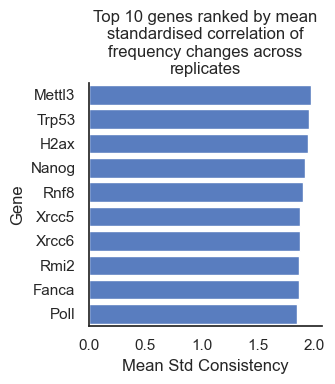

In [29]:
barplot_df = full_results_df.xs("Global", level=0, axis=1)["Mean Std Consistency"].sort_values(ascending=False)[:10].reset_index()

fig = plt.figure(figsize=(3.5, 4))
sns.barplot(data=barplot_df, x="Mean Std Consistency", y="Gene", color=sns.color_palette()[0])

plt.title("Top 10 genes ranked by mean\nstandardised correlation of\nfrequency changes across\nreplicates")
fig.tight_layout()

plt.gcf().savefig("artifacts/fig_6g.pdf")
plt.gcf().savefig("artifacts/fig_6g.png")


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

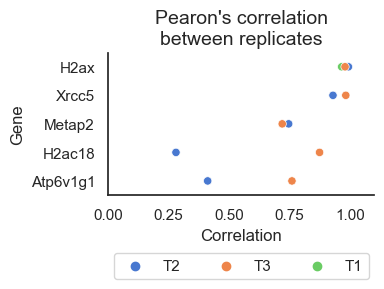

In [30]:
xlabel = "Correlation"
scatter_df = all_c.loc[["Atp6v1g1", "H2ac18", "Metap2", "Xrcc5", "H2ax"]].stack().reset_index().rename(columns={0: xlabel, "Sample": "Target"})

fig, ax = plt.subplots(figsize=(4, 3.5), sharey=True, sharex=True)
g = sns.scatterplot(data=scatter_df, x=xlabel, y="Gene", hue="Target", ax=ax)
sns.move_legend(g, 'upper center', ncol=3, bbox_to_anchor=(0.5, -0.35), title="")

plt.xlim((0, 1.1))
plt.ylim((-0.5, 4.5))
plt.title("Pearon's correlation\nbetween replicates", fontsize=14)
plt.tight_layout()
plt.gcf().savefig("artifacts/fig_5b.png")
plt.gcf().savefig("artifacts/fig_5b.pdf")

In [31]:
all_c.loc[["Atp6v1g1", "H2ac18", "Metap2", "Xrcc5", "H2ax"]]

Sample,T1,T2,T3
Gene,,,
Atp6v1g1,NaN,0.411515,0.760414
H2ac18,NaN,0.280307,0.874688
Metap2,NaN,0.746774,0.720092
Xrcc5,NaN,0.930199,0.983248
H2ax,0.96607,0.994087,0.980151


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

''double-strand break repair'' vs. Other/Not Annotated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.530e-05 U_stat=1.083e+04


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

''double-strand break repair'' vs. Other/Not Annotated: Mann-Whitney-Wilcoxon test two-sided, P_val:6.894e-06 U_stat=2.169e+06


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

''double-strand break repair'' vs. Other/Not Annotated: Mann-Whitney-Wilcoxon test two-sided, P_val:3.528e-16 U_stat=3.174e+06


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

''double-strand break repair'' vs. Other/Not Annotated: Mann-Whitney-Wilcoxon test two-sided, P_val:6.570e-10 U_stat=3.046e+06


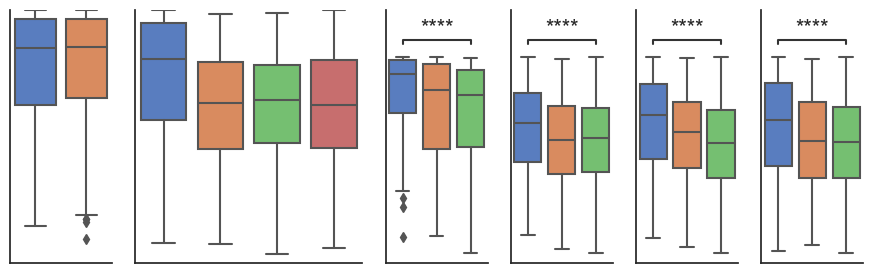

In [189]:
width = 14
height = 1

fig = plt.figure(figsize=(9, height * 3))

ax00 = plt.subplot2grid((height, width), (0, 0), colspan=2)
ax02 = plt.subplot2grid((height, width), (0, 2), colspan=4)
ax06 = plt.subplot2grid((height, width), (0, 6), colspan=2)
ax08 = plt.subplot2grid((height, width), (0, 8), colspan=2)
ax010 = plt.subplot2grid((height, width), (0, 10), colspan=2)
ax012 = plt.subplot2grid((height, width), (0, 12), colspan=2)

plot_correlation_of_changes_in_frequency_relative_to_geomean(ax00, real_c, pseudo_c)
plot_correlation_of_changes_to_geomean(ax02, adamson_t1, t1, t2, t3)
corr_of_changes_across_GO_annotations([ax06, ax08, ax010, ax012], full_results_df)

plt.tight_layout()

plt.show()

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

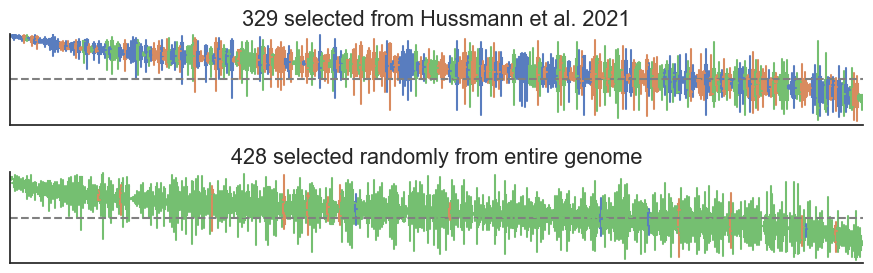

In [199]:
width = 1
height = 2

fig = plt.figure(figsize=(9, height * 1.5))

ax00 = plt.subplot2grid((height, width), (0, 0))
ax10 = plt.subplot2grid((height, width), (1, 0))

corr_freq_change_across_replicates_annotated_by_GO_for_adamson(ax00, all_c)
corr_freq_change_across_replicates_annotated_by_GO_for_genome(ax10, all_c)

plt.tight_layout()

plt.show()

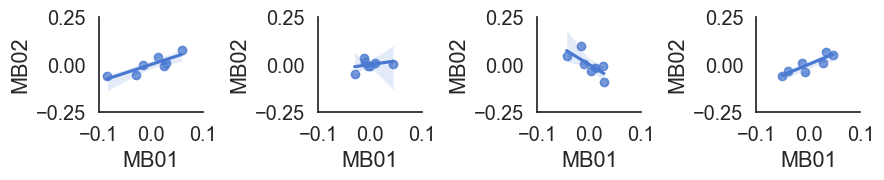

In [225]:
genes_to_plot = ["Mre11a", "Rad54b", "Lig4", "Xrcc6"]

width = 4
height = 1

fig = plt.figure(figsize=(9, height * 2))

ax00 = plt.subplot2grid((height, width), (0, 0))
ax10 = plt.subplot2grid((height, width), (0, 1))
ax01 = plt.subplot2grid((height, width), (0, 2))
ax11 = plt.subplot2grid((height, width), (0, 3))

# ax02 = plt.subplot2grid((height, width), (0, 2))
# ax12 = plt.subplot2grid((height, width), (1, 2))
# ax03 = plt.subplot2grid((height, width), (0, 3))
# ax13 = plt.subplot2grid((height, width), (1, 3))

# ax04 = plt.subplot2grid((height, width), (0, 4))
# ax14 = plt.subplot2grid((height, width), (1, 4))
# ax05 = plt.subplot2grid((height, width), (0, 5))
# ax15 = plt.subplot2grid((height, width), (1, 5))



def plot_gene(ax, df, gene, x, y):
    df = df[df["Gene"] == gene]
    sns.regplot(data=df, x=x,y=y, ax=ax)
    ax.set_ylim(-0.25, 0.25)
    ax.set_xlim(-0.1, 0.1)
    # ax.set_yticks([], [])
    # ax.set_xticks([], [])

x = "MB01"
y = "MB02"
plot_df = Xpseudodiff.T.loc[[x, y]].stack().reset_index().pivot(index=["Gene", "lumc_category"], columns="Sample", values=0).reset_index()
plot_df = plot_df[plot_df["Gene"].isin(genes_to_plot)]
plot_gene(ax00, plot_df, genes_to_plot[0], x, y)
plot_gene(ax10, plot_df, genes_to_plot[1], x, y)
plot_gene(ax01, plot_df, genes_to_plot[2], x, y)
plot_gene(ax11, plot_df, genes_to_plot[3], x, y)


# x = "MB03"
# y = "MB04"
# plot_df = Xpseudodiff.T.loc[[x, y]].stack().reset_index().pivot(index=["Gene", "lumc_category"], columns="Sample", values=0).reset_index()
# plot_df = plot_df[plot_df["Gene"].isin(genes_to_plot)]
# plot_gene(ax02, plot_df, genes_to_plot[0], x, y)
# plot_gene(ax12, plot_df, genes_to_plot[1], x, y)
# plot_gene(ax03, plot_df, genes_to_plot[2], x, y)
# plot_gene(ax13, plot_df, genes_to_plot[3], x, y)

# x = "MB05"
# y = "MB06"
# plot_df = Xpseudodiff.T.loc[[x, y]].stack().reset_index().pivot(index=["Gene", "lumc_category"], columns="Sample", values=0).reset_index()
# plot_df = plot_df[plot_df["Gene"].isin(genes_to_plot)]
# plot_gene(ax04, plot_df, genes_to_plot[0], x, y)
# plot_gene(ax14, plot_df, genes_to_plot[1], x, y)
# plot_gene(ax05, plot_df, genes_to_plot[2], x, y)
# plot_gene(ax15, plot_df, genes_to_plot[3], x, y)

plt.tight_layout()

plt.show()